# CNN for Handwritten Prescription Classification

In [1]:
import kagglehub
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
# print(os.listdir(path))
# csv_path = os.path.join(path, 'Doctor’s Handwritten Prescription BD dataset')
# print(os.listdir(csv_path))
# train_path = os.path.join(csv_path, 'Training')
# print(os.listdir(train_path))
# train2 = os.path.join(train_path, 'training_words')
# print(os.listdir(train2))

In [3]:
root = kagglehub.dataset_download("mamun1113/doctors-handwritten-prescription-bd-dataset")
ds_dir = os.path.join(root, "Doctor’s Handwritten Prescription BD dataset")

train_csv = os.path.join(ds_dir, "Training",    "training_labels.csv")
train_img = os.path.join(ds_dir, "Training",    "training_words")
val_csv   = os.path.join(ds_dir, "Validation",  "validation_labels.csv")
val_img   = os.path.join(ds_dir, "Validation",  "validation_words")
test_csv = os.path.join(ds_dir, "Testing", "testing_labels.csv")
test_img = os.path.join(ds_dir, "Testing", "testing_words")

train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

train_df["filepath"] = train_df["IMAGE"].apply(lambda fn: os.path.join(train_img, fn))
val_df  ["filepath"] = val_df["IMAGE"].apply(lambda fn: os.path.join(val_img, fn))
test_df["filepath"] = test_df["IMAGE"].apply(lambda fn: os.path.join(test_img, fn))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
train_gen = train_datagen.flow_from_dataframe(
    dataframe    = train_df,
    x_col        = "filepath",
    y_col        = "MEDICINE_NAME",
    target_size  = (128,128),
    batch_size   = 64,
    class_mode   = "categorical",
    shuffle      = True,
    seed         = 42
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_gen = val_datagen.flow_from_dataframe(
    dataframe    = val_df,
    x_col        = "filepath",
    y_col        = "MEDICINE_NAME",
    target_size  = (128,128),
    batch_size   = 64,
    class_mode   = "categorical",
    shuffle      = False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(
    dataframe   = test_df,
    x_col       = "filepath",
    y_col       = "MEDICINE_NAME",
    target_size = (128,128),
    batch_size  = 32,
    class_mode  = "categorical",
    shuffle     = False
)

Found 3120 validated image filenames belonging to 78 classes.
Found 780 validated image filenames belonging to 78 classes.
Found 780 validated image filenames belonging to 78 classes.


In [4]:
model = Sequential([
    Input(shape=(128, 128, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(78, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 78)             │        10,062 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,314,702 (12.64 MB)

 Trainable params: 3,314,702 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
epochs = 100
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 704ms/step - accuracy: 0.0154 - loss: 4.5112 - val_accuracy: 0.0308 - val_loss: 4.3382
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 358ms/step - accuracy: 0.0186 - loss: 4.3278 - val_accuracy: 0.0436 - val_loss: 4.2060
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 375ms/step - accuracy: 0.0341 - loss: 4.2474 - val_accuracy: 0.0615 - val_loss: 4.0870
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 354ms/step - accuracy: 0.0460 - loss: 4.1994 - val_accuracy: 0.0962 - val_loss: 3.9520
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0619 - loss: 4.0848 - val_accuracy: 0.0974 - val_loss: 3.8888
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 355ms/step - accuracy: 0.0693 - loss: 4.0463 - val_accuracy: 0.1526 - val_loss: 3.7073
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 374ms/step - accuracy: 0.0848 - loss: 3.9432 - val_accuracy: 0.1872 - val_loss: 3.5165
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 358ms/step - accuracy: 0.1078 - loss: 3.8173 - 

In [6]:
loss, acc = model.evaluate(val_gen)
print(f"Validation accuracy: {acc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8802 - loss: 0.6016 
Validation accuracy: 0.8718


In [7]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.8111 - loss: 0.9869
Test Loss: 1.2873
Test Accuracy: 0.7641


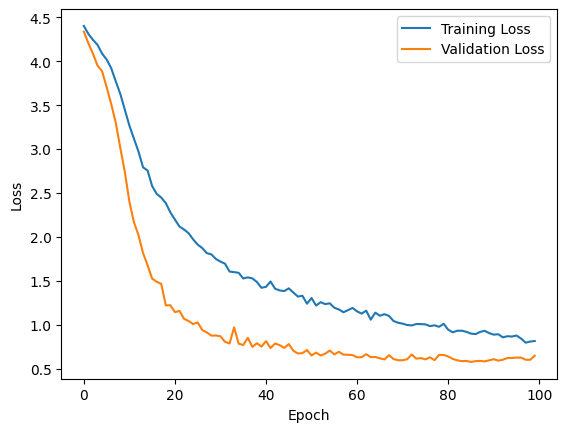

In [8]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

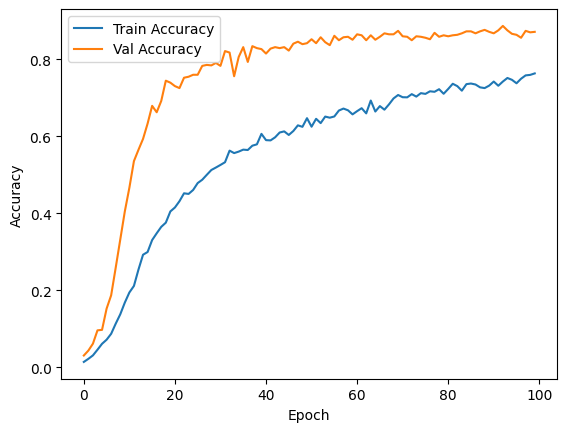

In [9]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()